# Exploring the Monodromic K-Essence model

In this notebook, I try to reproduce some figures from https://arxiv.org/pdf/1709.01544.pdf. I will refer to equations and figures in the paper.

Author: João Victor Rebouças, March 2024

In [1]:
from copy import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Units: assume reduced natural units: $c = 8 \pi G = \hbar = 1$

In [3]:
# Fixed parameters
h = 0.6756
omega_m = 0.27
omega_phot = 2.47e-5/h**2
omega_massless_nu = 3*(7/8)*(4/11)**(4/3)*omega_phot
omega_r = omega_phot + omega_massless_nu
omega_de = 1 - omega_m - omega_r
rho_cr = 3

## Equations:
The K-Essence action is given by:

$\int d^4x \sqrt{-g}F(X, \phi)$,

where

$X = \frac{\dot{\phi}^2}{2}$.

Our choice is:

$F = V(\phi)(-X + X^2)$,

and thus:

$\frac{\partial F}{\partial X} = V(\phi)(-1 + 2X)$

$\frac{\partial F}{\partial \phi} = V'(\phi)(-X + X^2)$

$\frac{\partial^2 F}{\partial X^2} = 2V(\phi)$

$\frac{\partial^2 F}{\partial X \partial \phi} = V'(\phi)(-1 + 2X)$

and the equation of motion for $X$ is:

$V(\phi)(-1 + 2X + 4X)\dot{X} + \sqrt{2X}(2XV'(\phi)(-1 + 2X) - V'(\phi)(-X + X^2)) + 6HXV(\phi)(-1 + 2X) = 0$

$V(\phi)(-1 + 6X)\dot{X} + V'(\phi)\sqrt{2X}(-X + 3X^2) + 6HV(\phi)X(-1 + 2X) = 0$

$\dot{X} =  \frac{-V'(\phi)\sqrt{2X}(-X + 3X^2) - 6HV(\phi)X(-1 + 2X)}{V(\phi)(6X - 1)}$

I want to evolve $\phi$ and $X$ in $a$

In [52]:
class Params:
	def __init__(self, C=rho_cr, A=0.05, alpha=0.2, nu=50):
		self.C = C
		self.A = A
		self.alpha = alpha
		self.nu = nu
	def __repr__(self):
		return f"C = {self.C}; alpha = {self.alpha}; A = {self.A}; nu = {self.nu}"

def V(phi: float, p: Params):
	return p.C*phi**(-p.alpha)*(1 - p.A*np.sin(p.nu*phi))

def V_derivative(phi: float, p: Params):
	return p.C*(-p.alpha*phi**(-p.alpha-1)*(1 - p.A*np.sin(p.nu*phi)) - phi**(-p.alpha)*p.A*p.nu*np.cos(p.nu*phi))

def rho_phi(phi: float, X: float, p: Params):
	return 2*X*V(phi, p)*(2*X - 1)

def Hubble(y: list[float], a: float, p: Params) -> float:
	phi, X = y
	rho = rho_cr*(omega_r*a**(-4) + omega_m*a**(-3)) + rho_phi(phi, X, p)
	return np.sqrt(rho/3)

def equations(y: list[float], a: float, p: Params) -> list[float]:
	phi, X = y
	H = Hubble(y, a, p)
	dphi = np.sqrt(2*X*rho_cr)/(a*H)
	dX = -V_derivative(phi, p)*np.sqrt(2*X)*(-X + 3*X**2)/(V(phi, p)*(6*X - 1)) - 6*H*X*(2*X - 1)/(6*X - 1) # dX/dt
	dX /= a*H
	return np.array([dphi, dX])

def equations_loga(y: list[float], loga: float, p: Params) -> list[float]:
	a = np.exp(loga)
	derivs = equations(y, a, p)
	return a*derivs

def integrate_cosmo(ic: list[float], a_ini: float, a_end: float, n_steps: int, p: Params) -> list[list[float], list[float]]:
	# Integrates first with respect to log(a)
	frac = 0.3 # The user provides the total number of time steps, `frac` is the fraction of time-steps spent in log integration
	a_treshold = 1e-3 # Scale factor to switch between log integration and normal integration
	n_steps_log = int(frac*n_steps)
	a_log = np.logspace(np.log10(a_ini), np.log10(a_treshold), n_steps_log)
	loga = np.log(a_log)
	result_log = odeint(equations_loga, ic, loga, args=(p,))
	ic_normal_integration = result_log[-1] # Initial conditions of normal integration is final state of log integration
	a = np.linspace(a_treshold, a_end, n_steps-n_steps_log)
	result_normal = odeint(equations, ic_normal_integration, a, args=(p,))
	return np.concatenate((a_log, a)), np.concatenate((result_log, result_normal))

def find_omega_de_0(result, p: Params):
	phi, X = result.T
	rho_phi_0 = rho_phi(phi[-1], X[-1], p)
	return rho_phi_0/rho_cr

def get_initial_phi_X(a_ini, pars):
	H0 = 100*h
	H_ini = H0*np.sqrt(omega_m*a_ini**(-3) + omega_r*a_ini**(-4))
	t_ini = 1/(2*H_ini)
	X_bar = (4-pars.alpha)/(8-3*pars.alpha)	
	phi_i = np.sqrt(2*X_bar*rho_cr)*t_ini
	return phi_i, X_bar

def solve_system(a_ini, a_end, n_steps, p):
	print("-----")
	print(f"Begin shooting for C")
	print(f"Target omega_de: {omega_de:.6f}")

	# Initial guesses for shooting parameters
	C_1 = 1.15*rho_cr*omega_de
	C_2 = 0.9*rho_cr*omega_de
	p_1 = copy(p)
	p_2 = copy(p)
	p_1.C = C_1
	p_2.C = C_2
	
	ic = [0, 0]
	# Integrate KG with initial guesses
	ic = get_initial_phi_X(a_ini, p_1)
	a, result_1 = integrate_cosmo(ic, a_ini, a_end, n_steps, p_1)
	ic = get_initial_phi_X(a_ini, p_2)
	a, result_2 = integrate_cosmo(ic, a_ini, a_end, n_steps, p_2)	

	omega_de_1 = find_omega_de_0(result_1, p_1)
	omega_de_2 = find_omega_de_0(result_2, p_2)
	
	# Assess errors at initial guesses
	error_de_1 = (omega_de_1 - omega_de)/omega_de
	error_de_2 = (omega_de_2 - omega_de)/omega_de

	print(f"C = {C_1:.6f} => omega_de = {omega_de_1:.6f} (error = {error_de_1:.6f})")
	print(f"C = {C_2:.6f} => omega_de = {omega_de_2:.6f} (error = {error_de_2:.6f})")

	# TODO: Secant method does not require initial guesses to enclose solution
	encapsulating = (omega_de_1 - omega_de)*(omega_de_2 - omega_de) < 0
	if not encapsulating:
		print("WARNING: initial guesses for V0 did not encapsulate the target omega_de")
		print(f"  Target omega_de: {omega_de}")
		print(f"  C = {C_1:.6f} => omega_de = {omega_de_1:.6f}")
		print(f"  C = {C_2:.6f} => omega_de = {omega_de_2:.6f}")
	
	iters = 0
	max_iters = 20
	while (iters < max_iters):
		iters += 1

		# Fit a line between (C_1, omega_de_1) and (C_2, omega_de_2)
		a_line = (omega_de_2 - omega_de_1)/(C_2 - C_1)
		b_line = omega_de_2 - a_line*C_2

		# Choose the point where the line would cross the target omega_de
		C_try = (omega_de - b_line)/a_line
		p.C = C_try
		ic = get_initial_phi_X(a_ini, p)

		# Integrate KG assuming this new V0
		a, result_try = integrate_cosmo(ic, a_ini, a_end, n_steps, p)
		
		# Evaluate omega_de for new point
		omega_de_try = find_omega_de_0(result_try, p)
		
		# Assess errors at new point
		error = (omega_de_try - omega_de)/omega_de
		print(f"C = {C_try:.6f} => omega_de = {omega_de_try:.6f} (error = {error:.6f})")
		
		# Exit condition
		if abs(error) < 1e-4: break

		# Substitute one of the initial C guesses by the new C guess
		if (omega_de_try > omega_de):
			C_1 = C_try
			omega_de_1 = omega_de_try
		else:
			C_2 = C_try
			omega_de_2 = omega_de_try
		
	if error > 1e-4:
		print(f"WARNING: reached max iterations in shooting with error = {error}")
	else:
		print(f"Finished shooting successfully after {iters} iterations")
	return a, result_try

In [53]:
# Getting results
a_ini = 1e-5
n_steps = 20_000

cases = [
	Params(A=0),
	Params(A=0.5, nu=20),
	Params(A=0.3, nu=50),
]
results = []
for case in cases:
	a, result = solve_system(a_ini, 1, n_steps, case)
	results.append(result)

-----
Begin shooting for C
Target omega_de: 0.729909
C = 2.518186 => omega_de = 0.010887 (error = -0.985084)
C = 1.970754 => omega_de = 0.008531 (error = -0.988313)
  Target omega_de: 0.7299090152606962
  C = 2.518186 => omega_de = 0.010887
  C = 1.970754 => omega_de = 0.008531
C = 169.534671 => omega_de = 0.617520 (error = -0.153977)
C = 200.477281 => omega_de = 0.718431 (error = -0.015725)
C = 203.688499 => omega_de = 0.728792 (error = -0.001530)
C = 204.001440 => omega_de = 0.729801 (error = -0.000148)
C = 204.031749 => omega_de = 0.729899 (error = -0.000014)
Finished shooting successfully after 5 iterations
-----
Begin shooting for C
Target omega_de: 0.729909
C = 2.518186 => omega_de = 0.041874 (error = -0.942631)
C = 1.970754 => omega_de = 0.033074 (error = -0.954687)
  Target omega_de: 0.7299090152606962
  C = 2.518186 => omega_de = 0.041874
  C = 1.970754 => omega_de = 0.033074
C = 45.320558 => omega_de = 0.092252 (error = -0.873612)
 lsoda--  at t (=r1), too much accuracy reque

/tmp/ipykernel_14116/2489853191.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rho/3)
/home/user/.local/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C = 68.136060 => omega_de = -0.190178 (error = -1.260550)
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6277369823877D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5211617379135D+00   r2 =                  NaN
C = 72.927077 => omega_de = 1.426632 (error = 0.954533)
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6254433789171D+00   r2 =                  NaN
C = 70.862511 => omega_de = 1.386244 (error = 0.899201)
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6264650242898D+00   r2 =                  NaN
C = 69.727367 => omega_de = -0.194619 (error = -1.266635)
 lsoda--  at t (=r1), too much accuracy requested    
  

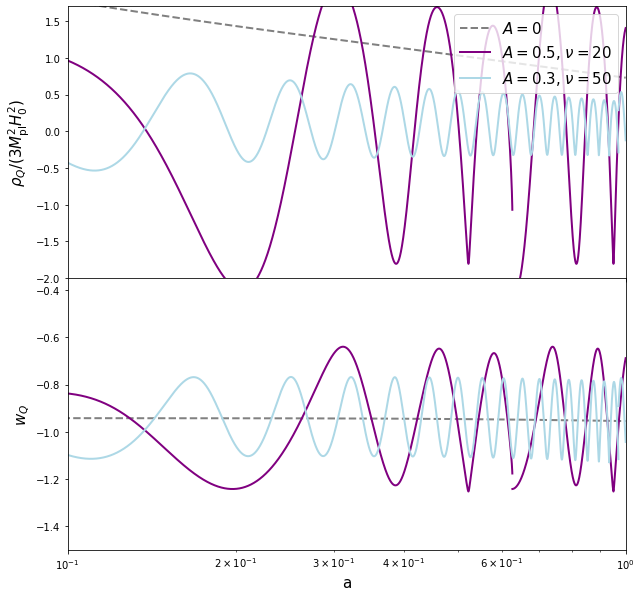

In [54]:
# Calculating densities for each case
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10), gridspec_kw={'hspace': 0})
rho_r_a = rho_cr* omega_r * a**(-4)
rho_m_a = rho_cr* omega_m * a**(-3)
lws = [2, 2, 2]
lss = ['--', '-', '-']
colors = ['gray', 'purple', 'lightblue']
legend_labels = [rf"$A = {case.A}$, $\nu = {case.nu}$" if case.A != 0 else rf"$A = {case.A}$" for case in cases]
for case, result, lw, ls, color, label in zip(cases, results, lws, lss, colors, legend_labels):
	phi, X = result.T
	rho_de_a = rho_phi(phi, X, case)
	w_de_a = (1-X)/(1-3*X)
	rho_de_a_lcdm = rho_cr*(1-omega_m-omega_r)*np.ones((n_steps))
	axs[0].semilogx(a, rho_de_a/rho_cr, color=color, ls=ls, lw=lw, label=label)
	axs[1].semilogx(a, w_de_a, color=color, ls=ls, lw=lw, label=label)

axs[0].set_ylabel(r"$\rho_Q/(3M^2_\mathrm{pl}H_0^2)$", fontsize=15)
axs[0].set_ylim([-2, 1.7])
axs[1].set_ylabel(r"$w_Q$", fontsize=15)
axs[1].set_ylim([-1.5, -0.35])
axs[0].set_xlim([0.1, 1])
axs[1].set_xlabel(r"a", fontsize=15)
axs[0].legend(loc="upper right", fontsize=15)
# plt.savefig("monodromic_quintessence_reproduction.pdf")

(0.01, 1)

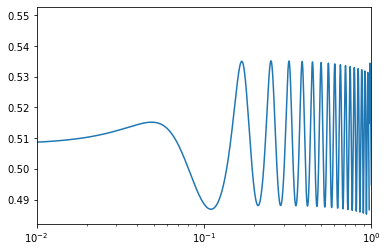

In [56]:
plt.semilogx(a, X)
plt.xlim([0.01, 1])

(0.01, 1)

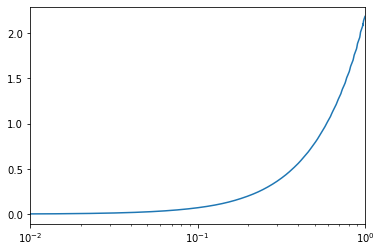

In [51]:
plt.semilogx(a, phi)
plt.xlim([0.01, 1])